# Modeling Continuous Targets: Building and Interpreting Bayesian Regressions

<br>

***

<br>

## Import Libraries

In [1]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import patsy
from datetime import timedelta, datetime
from scipy import stats
from sklearn.datasets import fetch_california_housing

print(f"PYMC Version {pm.__version__}")

PYMC Version 5.15.0


<br>

***

<br>

## Import Data

In [2]:

df = fetch_california_housing(as_frame=True)
df = df.frame
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

This dataset has 20640 rows and 9 columns


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<br>

***

<br>

## Explore Data

In [3]:
# Null values for features
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [4]:
# Tell me about the target
df['MedHouseVal'].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

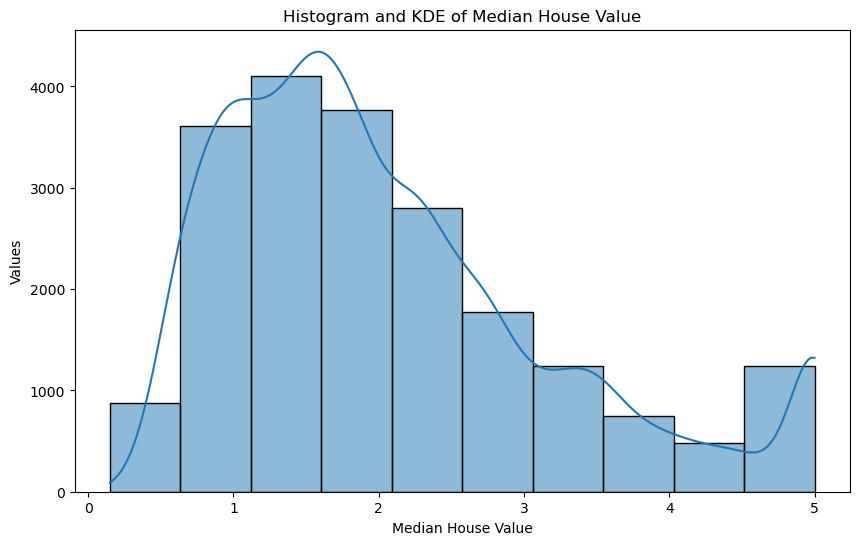

In [6]:
# Histogram & KDE plot of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseVal'], kde=True, bins=10)
plt.title('Histogram and KDE of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Values')
plt.show()

In [7]:
# ==================================================== #
# Optional to Standardize Variables                    #
# ==================================================== #

# pros: sampling efficiency (NUTS), numerical stability (MCMC), you can transform back to normal at the end (or not - interpret the standard deviation)
# I saw it go from 48 seconds to 16 seconds
# x_norm = (x - x.mean()) / x.std()

# Find Features
X = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]
y = df['MedHouseVal']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - y.mean()) / y.std()

# Convert scaled features to tensors
X_shared = pm.floatX(X_scaled)
y_shared = pm.floatX(y_scaled)

In [ ]:
%%time
# Naming your pm.Model and opening it up in the context editor to add and change parameters - could code this up differently but not recommended
with pm.Model() as bayesian_model:
    
    # priors
    # mu - the location or center or mean of your data - if you think your coef is + then make it positive, otherwise you can make it negative
    # sigma - the standard deviation or spread of your data - a large sd would indicate strong confidence in your prior, whereas a small sd indicates uncertainty
    # examples: mu=2, sigma=1, strong priors; mu=1 sigma=10, weak priors; mu=0, sigma=100, uninformative priors
    # Use priors to input domain knowledge, regularlization to avoid overfitting, and make small data more robus
    
    # intercept: represents the predicted value of the dependent variable when all independent variables are equal to zero
    # mu is 0 because we do not have a prior about the intercept
    # sigma is 10 because we have lots of uncertainty about the prior
    # the first variable is the python name which can be used to reference the variable
    # the second variable in quotes is PYMC variable name which is a label you'll see in your plots

    # Priors for intercept
    intercept = pm.Normal('Intercept', mu=0, sigma=1)

    # Betas - even if you have features that are binary, you model them all with normal distributions
    # This is because it's the variable that is binary, not the coefficient

    # Priors for each feature based on domain knowledge
    beta_medinc = pm.Normal("beta_medinc", mu=1, sigma=0.5)     # Expecting a positive influence
    beta_houseage = pm.Normal("beta_houseage", mu=0.5, sigma=0.5)  # Moderate positive effect
    beta_averagerooms = pm.Normal("beta_averagerooms", mu=1, sigma=0.5)  # Positive effect
    beta_aveoccup = pm.Normal("beta_aveoccup", mu=0, sigma=1)    # Neutral or negative effect
    beta_latitude = pm.Normal("beta_latitude", mu=0, sigma=1)    # Weak prior, location-specific
    beta_longitude = pm.Normal("beta_longitude", mu=0, sigma=1)  # Weak prior, location-specific

    # Another way of doing this if you have a lot of features
    # beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1] - 1)
    # logits = intercept + pm.math.dot(X.iloc[:, 1:], beta)
        # or this...
    # import pytensor.tensor as at
    # july_cpm_cert_drops = pm.Model(coords={"predictors": columns}) # outside of the pm.Model() context
    # beta = pm.Normal("beta", 0, 10, dims="predictors")
    # beta0 = pm.Normal("beta0", 0, 10)
    # mu = beta0 + at.dot(X_train, beta)

    # ==================================================== #
    # Logistic Likelihood                                  #
    # ==================================================== #

    # Regression Formula
    mu = (intercept 
          + beta_medinc * X_shared[:, 0] 
          + beta_houseage * X_shared[:, 1] 
          + beta_averagerooms * X_shared[:, 2] 
          + beta_aveoccup * X_shared[:, 3] 
          + beta_latitude * X_shared[:, 4] 
          + beta_longitude * X_shared[:, 5])

    # ==================================================== #
    # MCMC NUTS Process                                    #
    # ==================================================== #
    
    # Magic Inference Button
    # 2000 samples from the posterior distribution (2000-5000 is good, closer to 100000 is great)
    # More is better - the samples build up over time as it explores the space - only negative is time and resources
    # Increase when you have a complex model or want precision
    # Decrease when you don't have time or are prototyping
    # trace = pm.sample(4000, return_inferencedata=True)

    # Likelihood (sampling distribution) of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_shared)

    # sampling
    # -> 2000 Draws - 2000 is good, more is better, 5000 to 10000 is solid
    # -> 4 Chains - Ensure convergence & increase sampling diversity, improves stability
    # -> 1000 Tuning Steps - These will tune the sampler before your actual samples are taken
    # -> 0.9 Target Acceptance Rate - Recommended 0.8 to 0.95, higher is more accurate and stable, but slower

    # Inference Object
    trace = pm.sample(2000, chains=4, tune=1000, target_accept=0.9)
    # 1. Diagnostics for convergence -> they should overlap in the trace plots
    # 2. Avoiding local minima -> The chains are exploring a posterior space and can get caught in local regions of space
    # 3. Poor mixing happens when MCMC struggles to move across parameter space, multiple chains helps here
    # 4. Improves effectiveness of small sample sizes, improves autocorrelation and improves quality of inferences
    # Use for complex models, diagnositcs, uncertain priors, multi-modal posteriors


# After sampling, you can convert the coefficients back to the original scale:
# If needed, you can back-transform them for interpretability.
# beta_var1_original = trace['beta_var1'].mean() * x['var1'].std()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_medinc, beta_houseage, beta_averagerooms, beta_aveoccup, beta_latitude, beta_longitude, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 263 seconds.


CPU times: total: 33.8 s
Wall time: 4min 52s


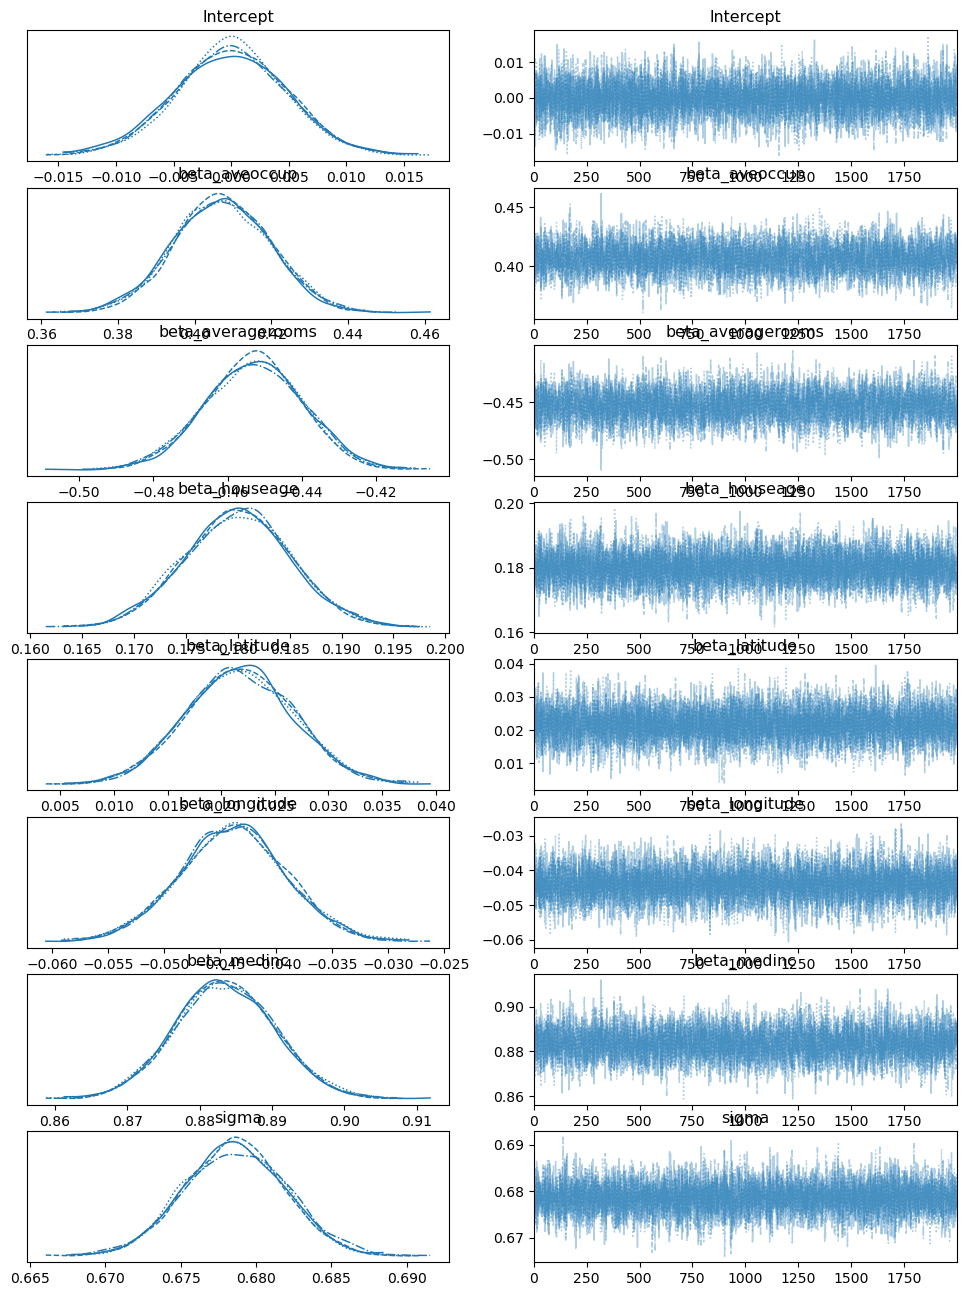

In [ ]:
# ==================================================== #
# Visualize Model Results & Diagnostics                #
# ==================================================== #

# Visualize Trace which gives us posterior distributions for the intercept and each beta coefficient

# Left #
#------#
# Posterior distribution plots show the range of values for each coefficient which can help us understand the uncertainty around the causal effect of the variable
# You want to see a normal distribution bell curve - shows the model converged properly; Skewed or multimodal is no good
# Wider distributions shows more uncertainty (narrow=more certainty, but they can be too narrow...)

# Right #
#-------#
# Trace plots: value of sampled parameter at each step of the MCMC process - look for a fuzzy catapillar
# After the inital "burn-in" period, it should look noisy but stable horizontal band - meaning it converged & is exploring the posterior distribution effectively
# It should not show any drift, it should be on the line of the mean
# It should also show good mixing of different values
# Sometimes you disgard the early samples that are part of that burn-in period (person does this, so ask him)

# Signals #
#---------#
# Trace plots that are sticky or deviating off the mean
# Trace plots with multiple chains that don't overlap
# Trade plots that are multi-modal
# Too wide or too narrow posterior distributions

# Diagnostics #
#-------------#
# Gelman-Rubin Stat (R-hat) -> check if chains have converged, < 1.1 means chains have converged
# Effective Sample Size -> How many ind samples the MCMC algorithm has drawn, if ESS is smaller than totla samples, then poor mixing
# Check for autocorrelation of MCMC samples
# Trace plots for multiple chains -> set chains=4 on the pm.sample function & check if the chains overlap for good convergence

az.plot_trace(trace);
# plt.show();
# while this may not look fantastic...google what a bad one looks like and you'll see this is perfectly a-okay

In [ ]:
# ==================================================== #
# Summarize Model Results                              #
# ==================================================== #
# Summary of the posterior distributions
# The 95% HDI shows where the bulk of the poterior mass lies
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.005,-0.010,0.009,0.0,0.0,9557.0,5546.0,1.0
beta_aveoccup,0.407,0.012,0.383,0.431,0.0,0.0,5186.0,5149.0,1.0
beta_averagerooms,-0.453,0.013,-0.478,-0.427,0.0,0.0,5076.0,4773.0,1.0
beta_houseage,0.180,0.005,0.170,0.190,0.0,0.0,7952.0,4965.0,1.0
beta_latitude,0.022,0.005,0.012,0.032,0.0,0.0,8729.0,5495.0,1.0
beta_longitude,-0.044,0.005,-0.053,-0.034,0.0,0.0,10160.0,5396.0,1.0
beta_medinc,0.884,0.007,0.870,0.897,0.0,0.0,5847.0,5363.0,1.0
sigma,0.679,0.003,0.672,0.685,0.0,0.0,9244.0,4621.0,1.0


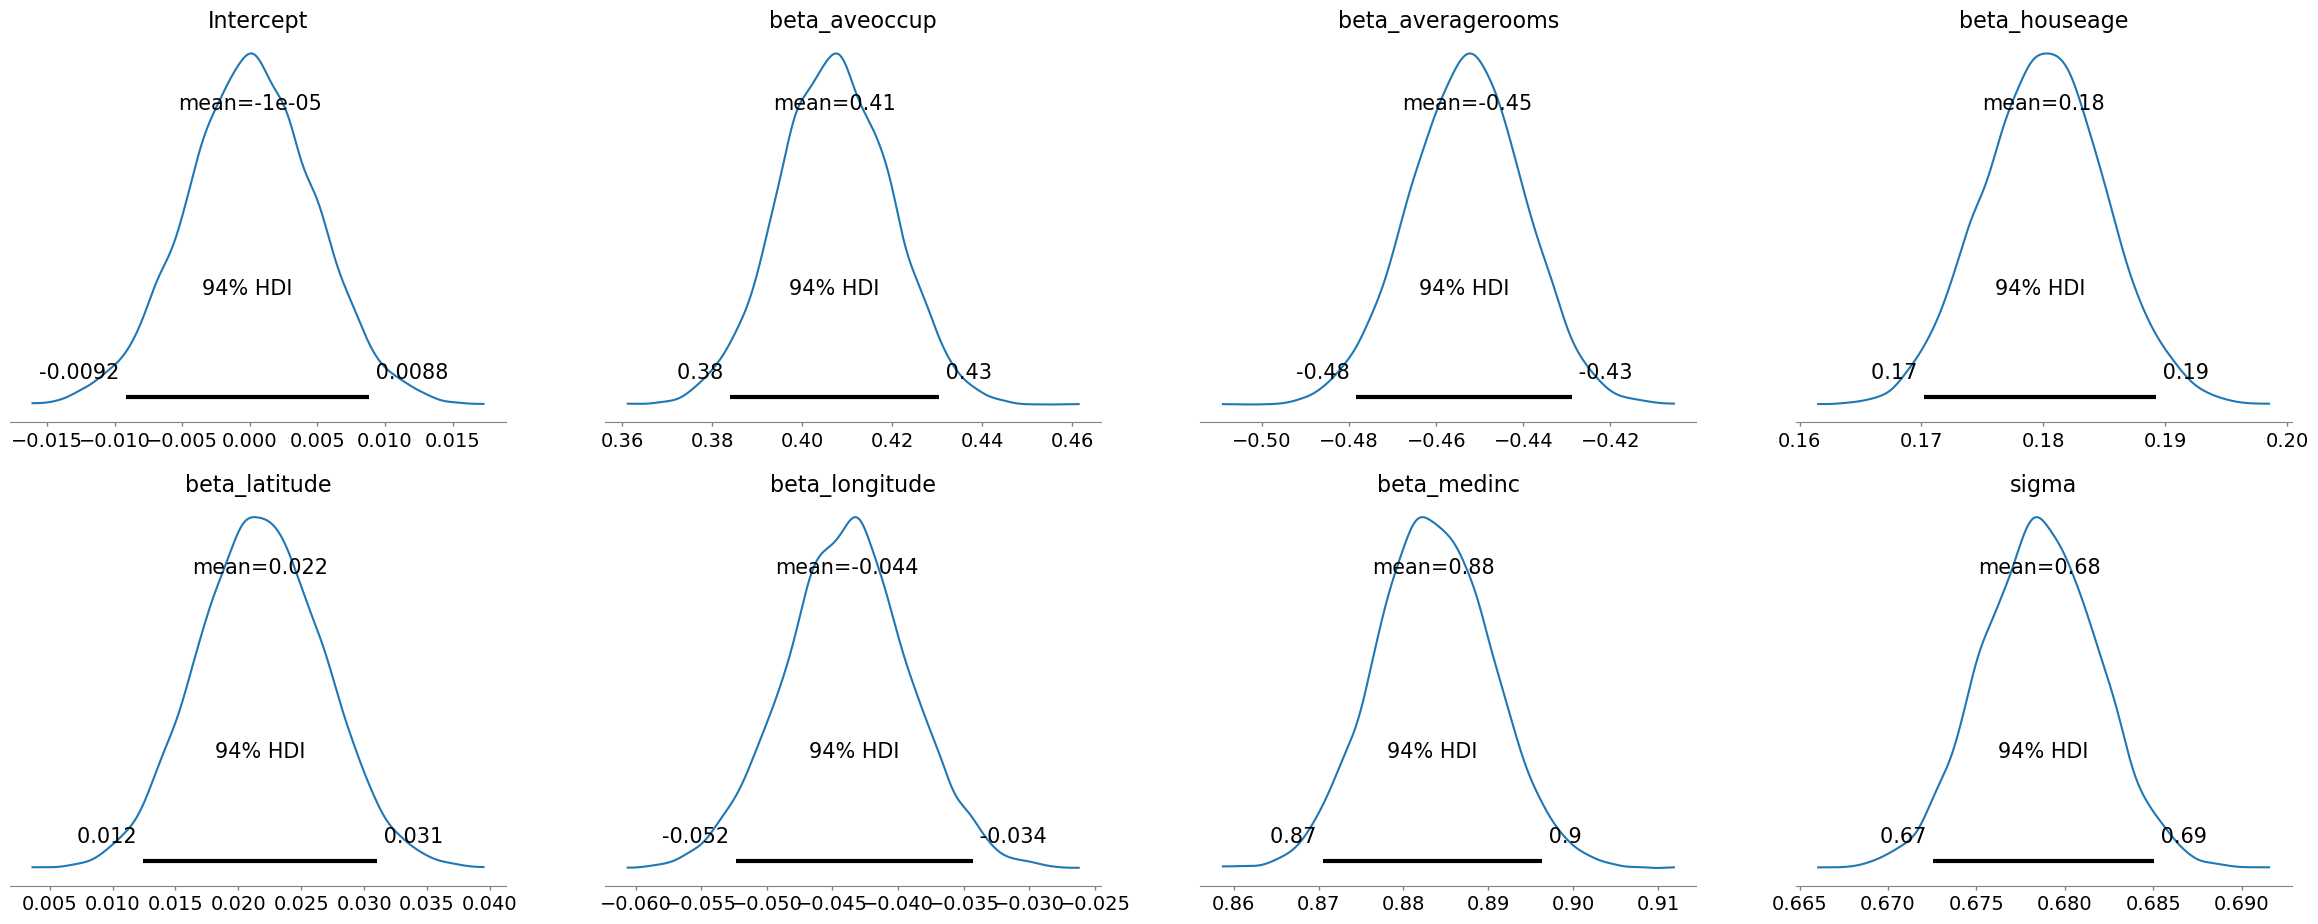

In [ ]:
az.plot_posterior(trace);

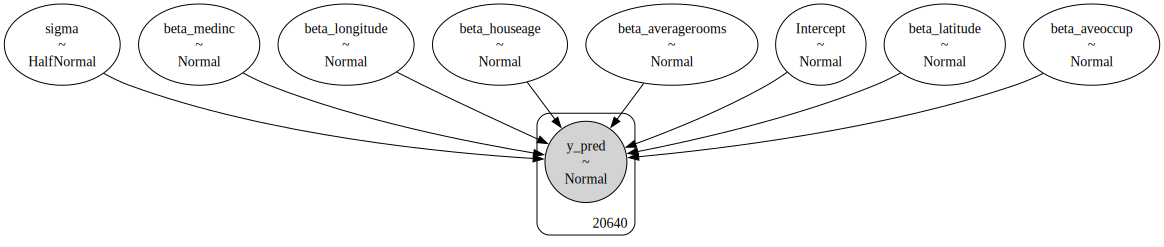

In [ ]:
# Graph out model structure
pm.model_to_graphviz(bayesian_model)

In [ ]:
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=bayesian_model)

Sampling: [y_pred]


Output()

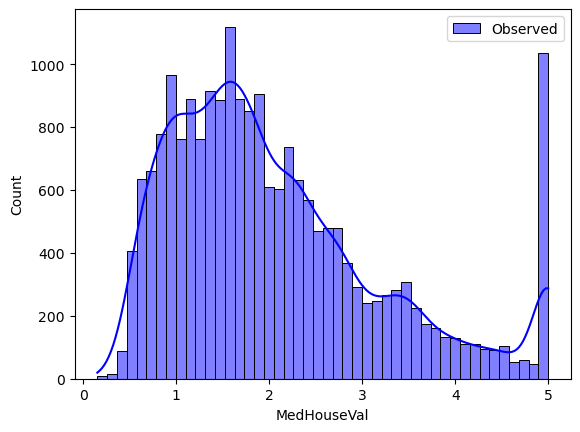

In [ ]:
# Compare observed data to simulated posterior data
sns.histplot(y, color='blue', label='Observed', kde=True)
# sns.histplot(ppc.posterior_predictive.y_pred.mean(axis=0), color='orange', label='Posterior Predictive', kde=True)
plt.legend()
plt.show()

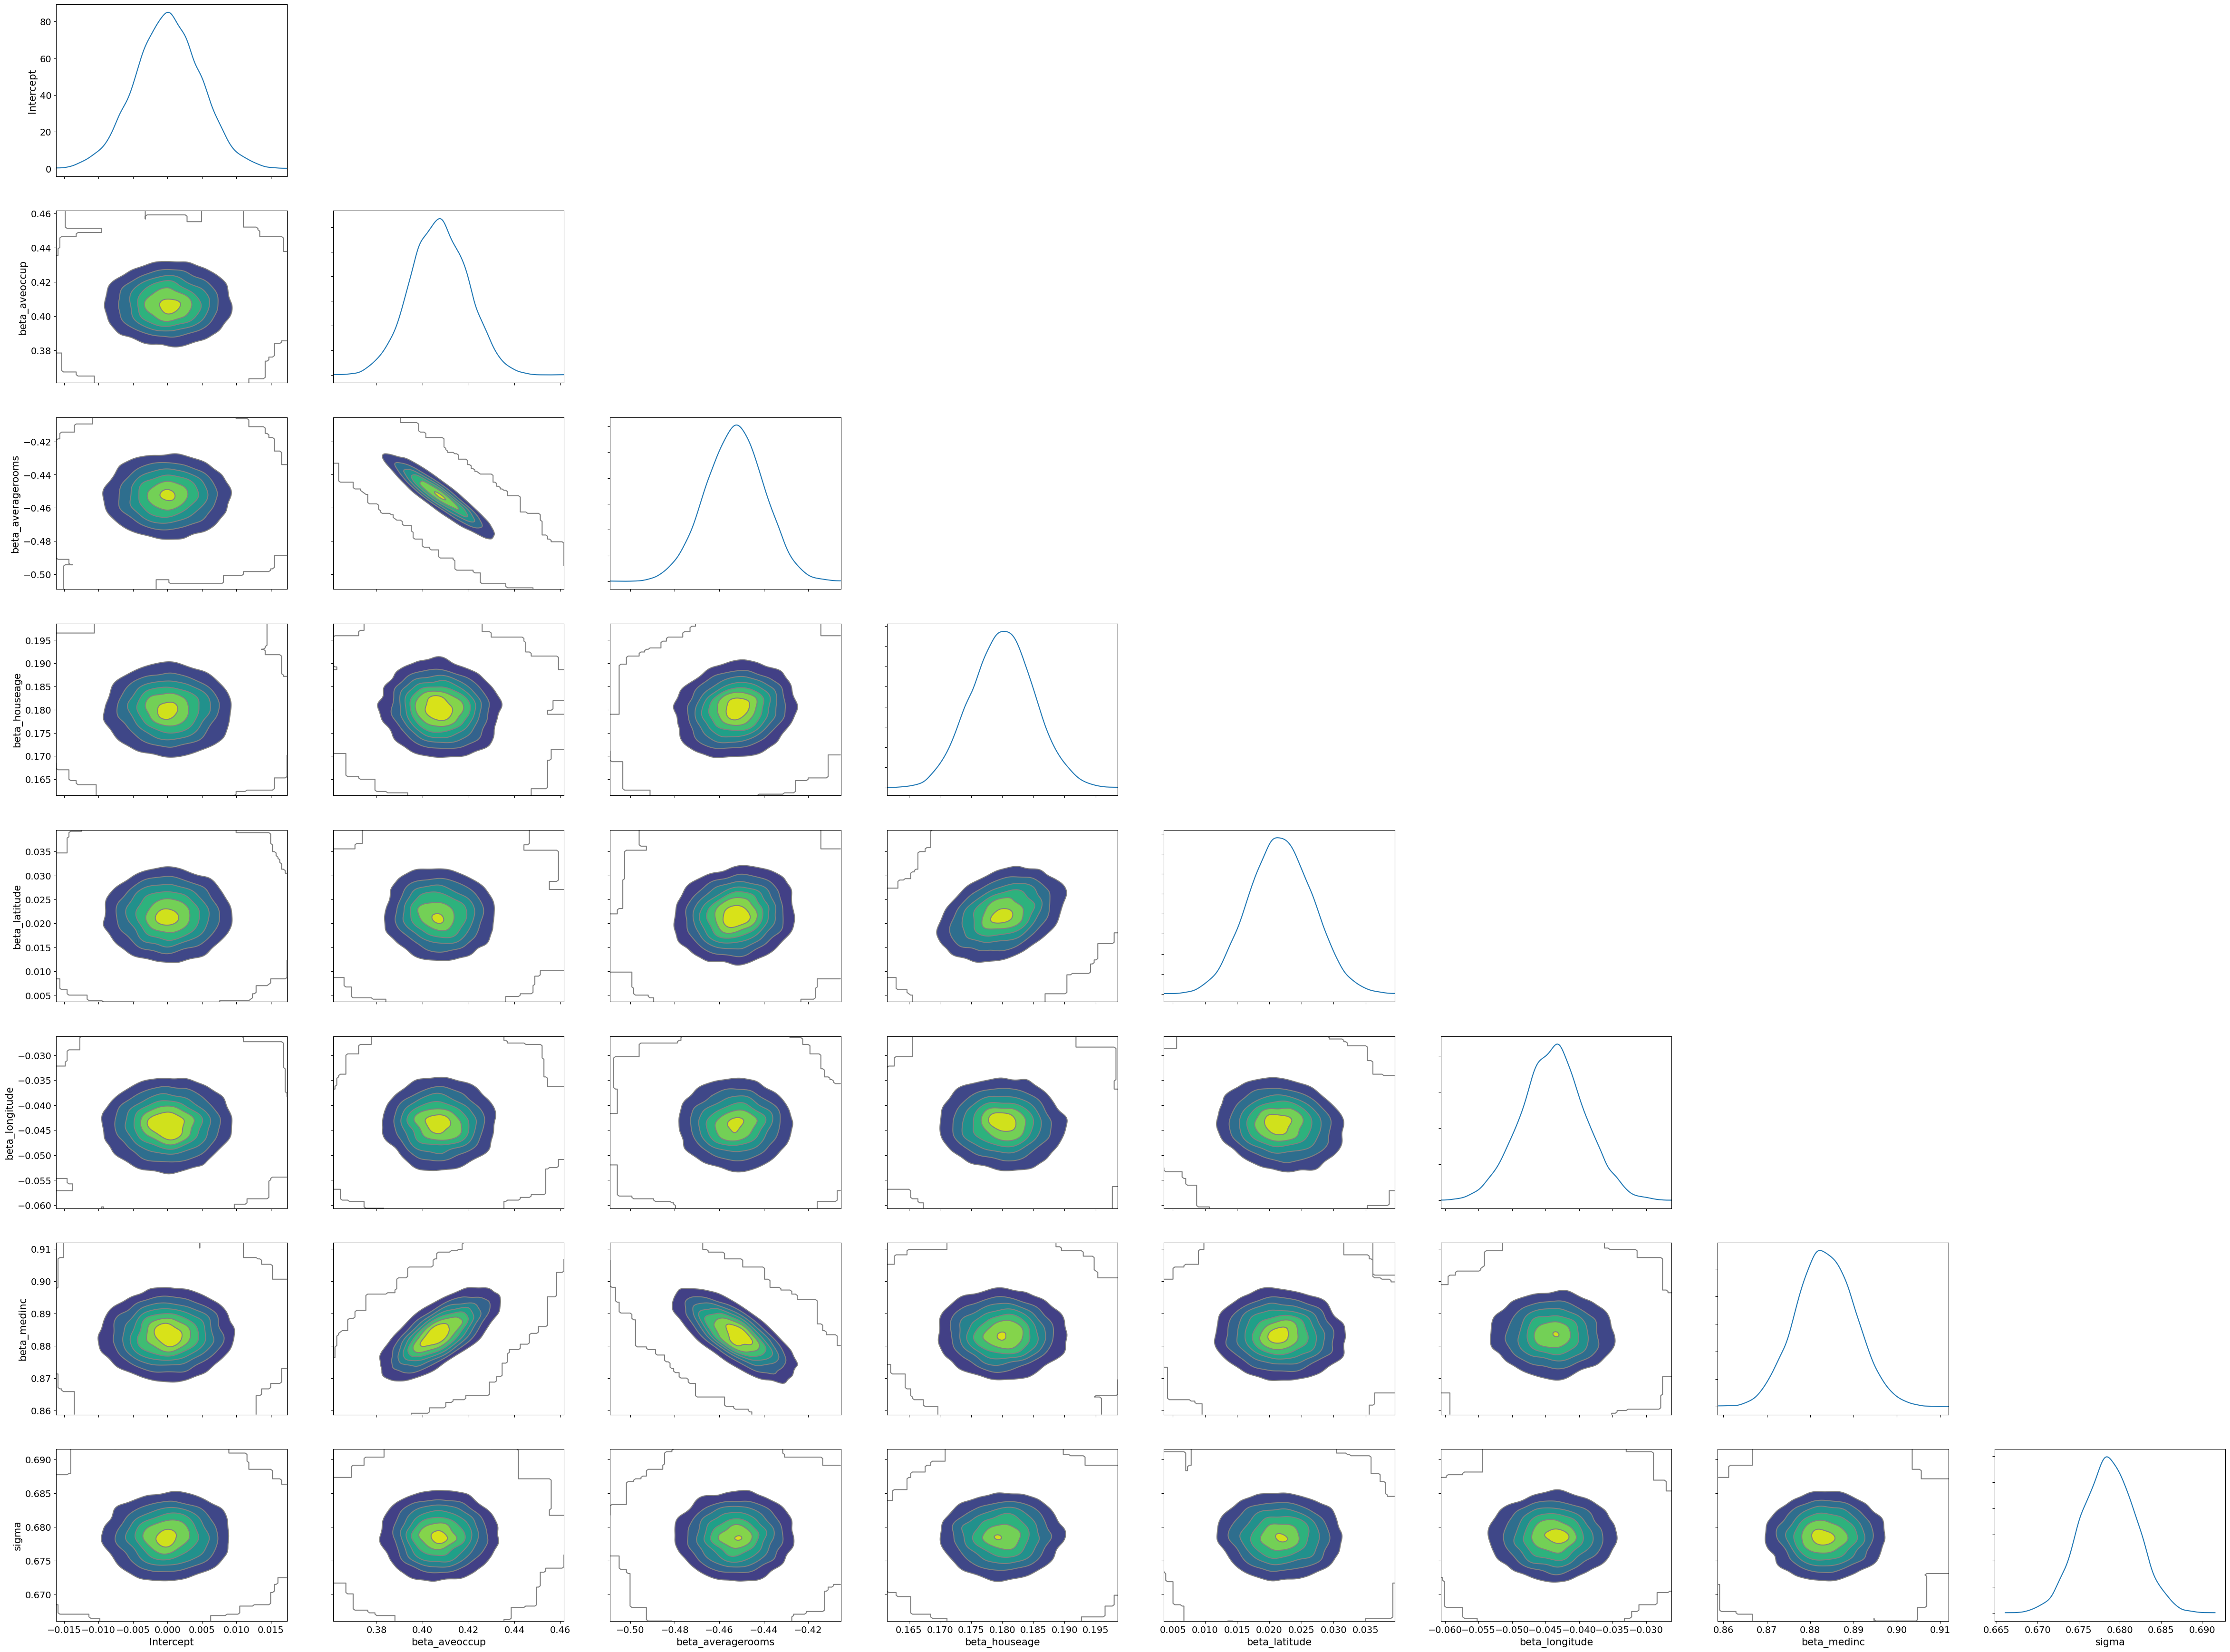

In [ ]:
# Pair Plot (Joint Posterior Distributions)
az.plot_pair(trace, kind="kde", marginals=True);

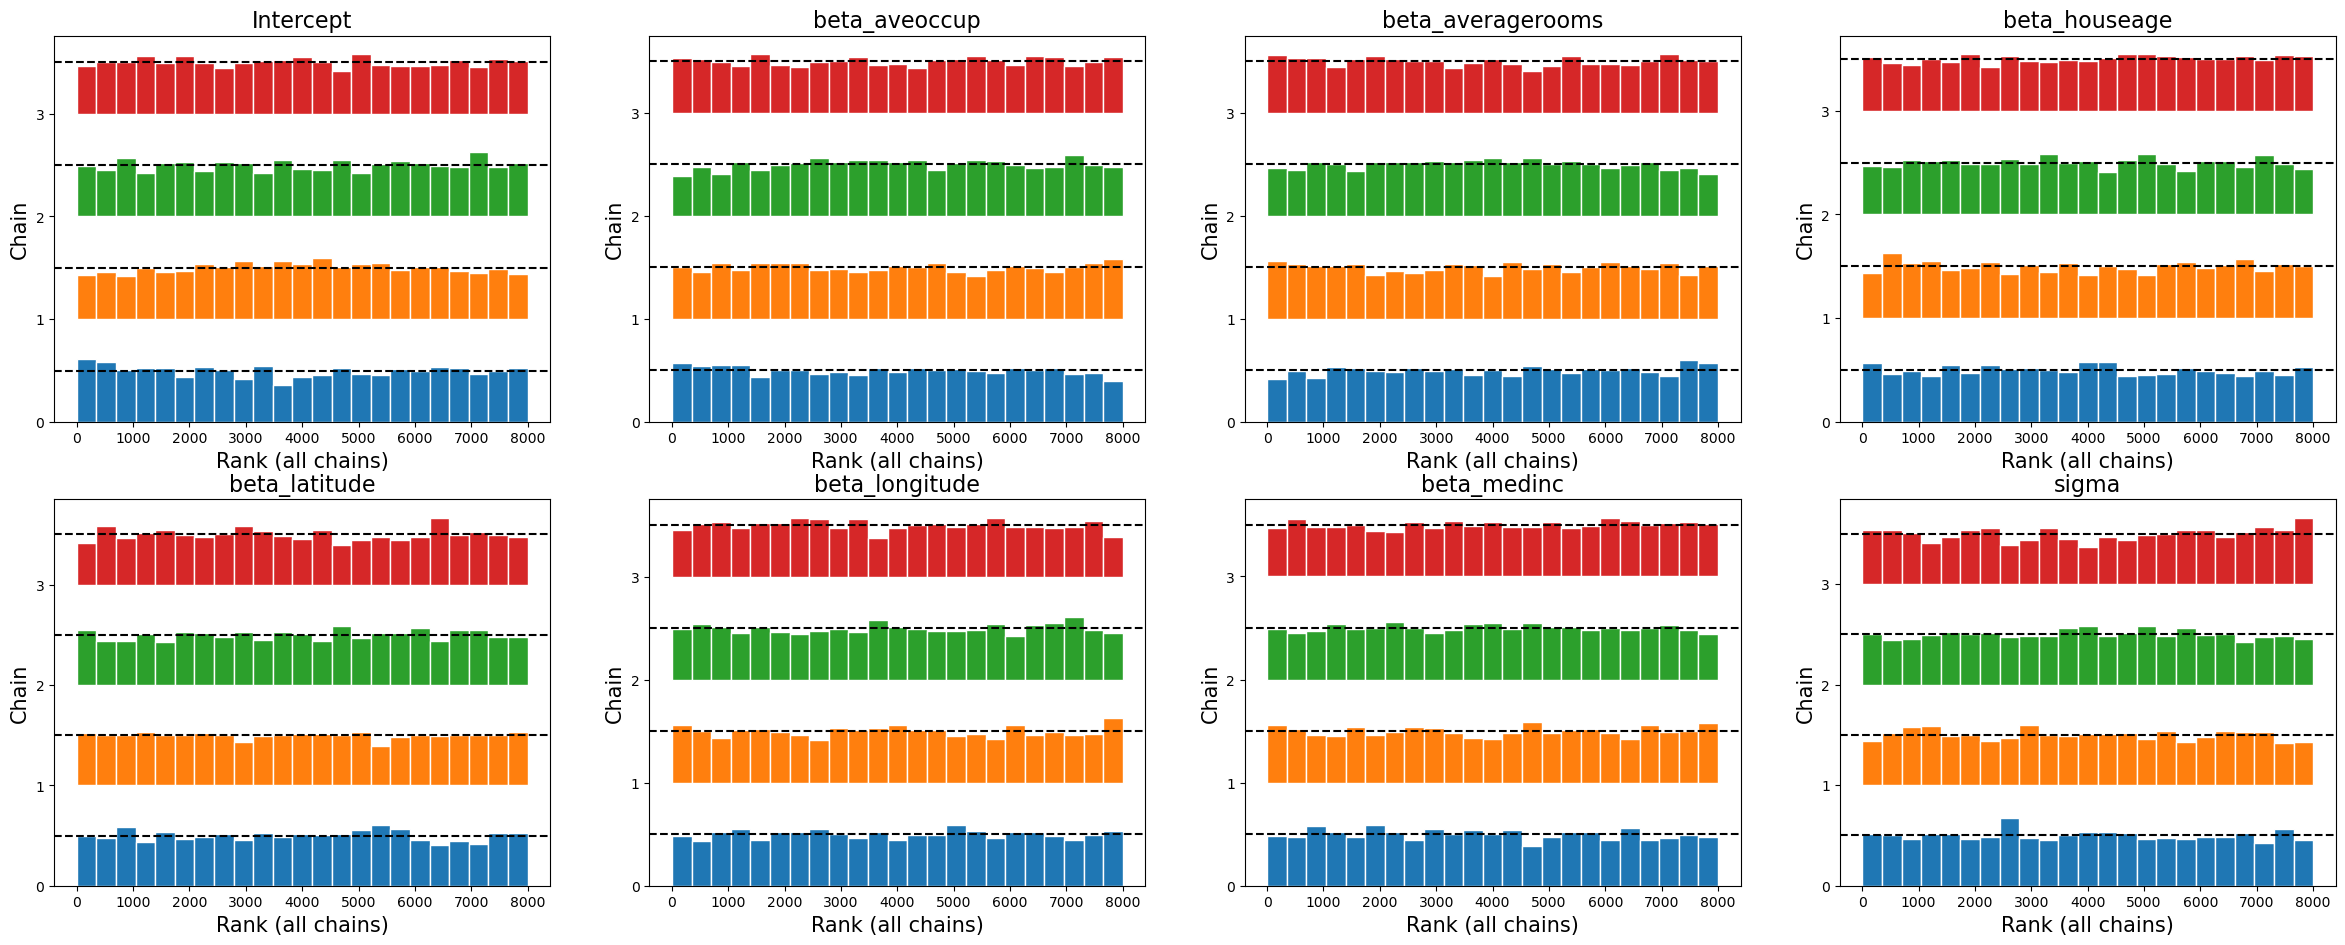

In [ ]:
# Rank Plot
az.plot_rank(trace);
plt.show();

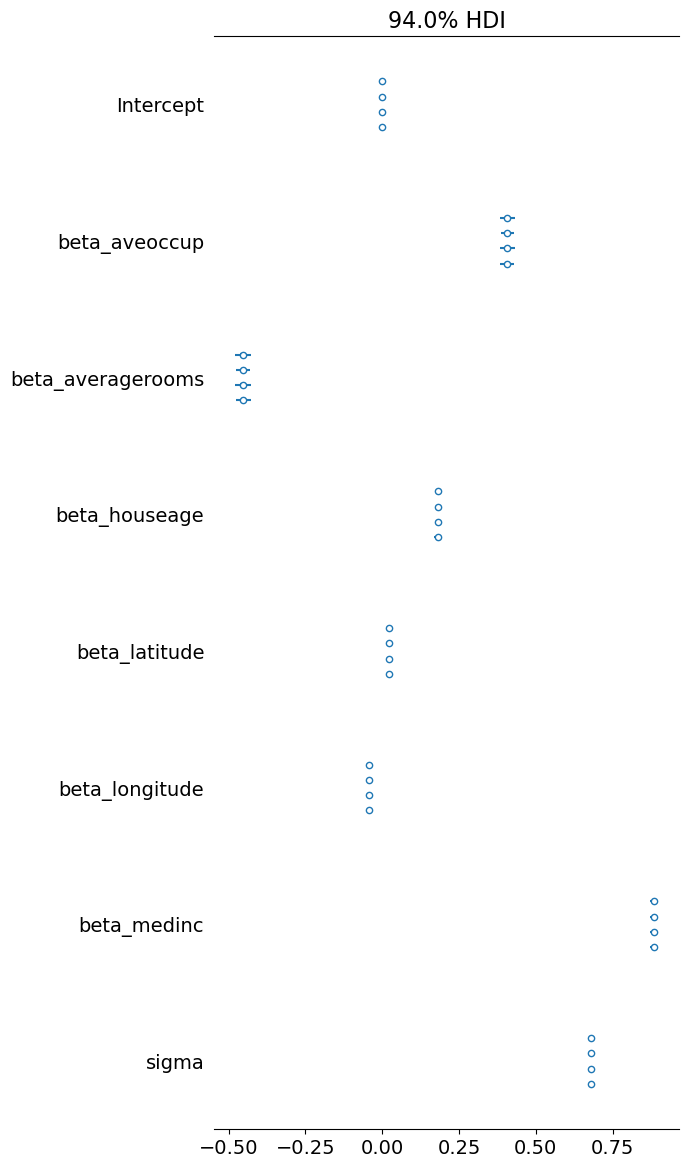

In [ ]:
# Posterior Interval Plot (HDI Plot)
az.plot_forest(trace);

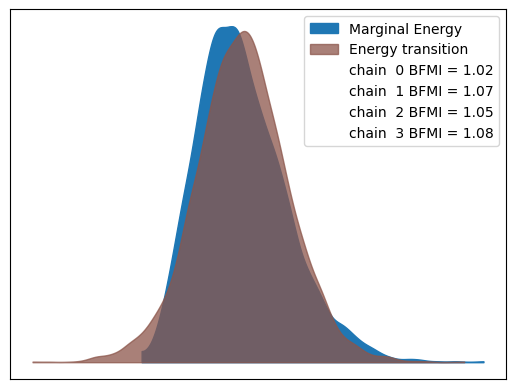

In [ ]:
az.plot_energy(trace)
plt.show()

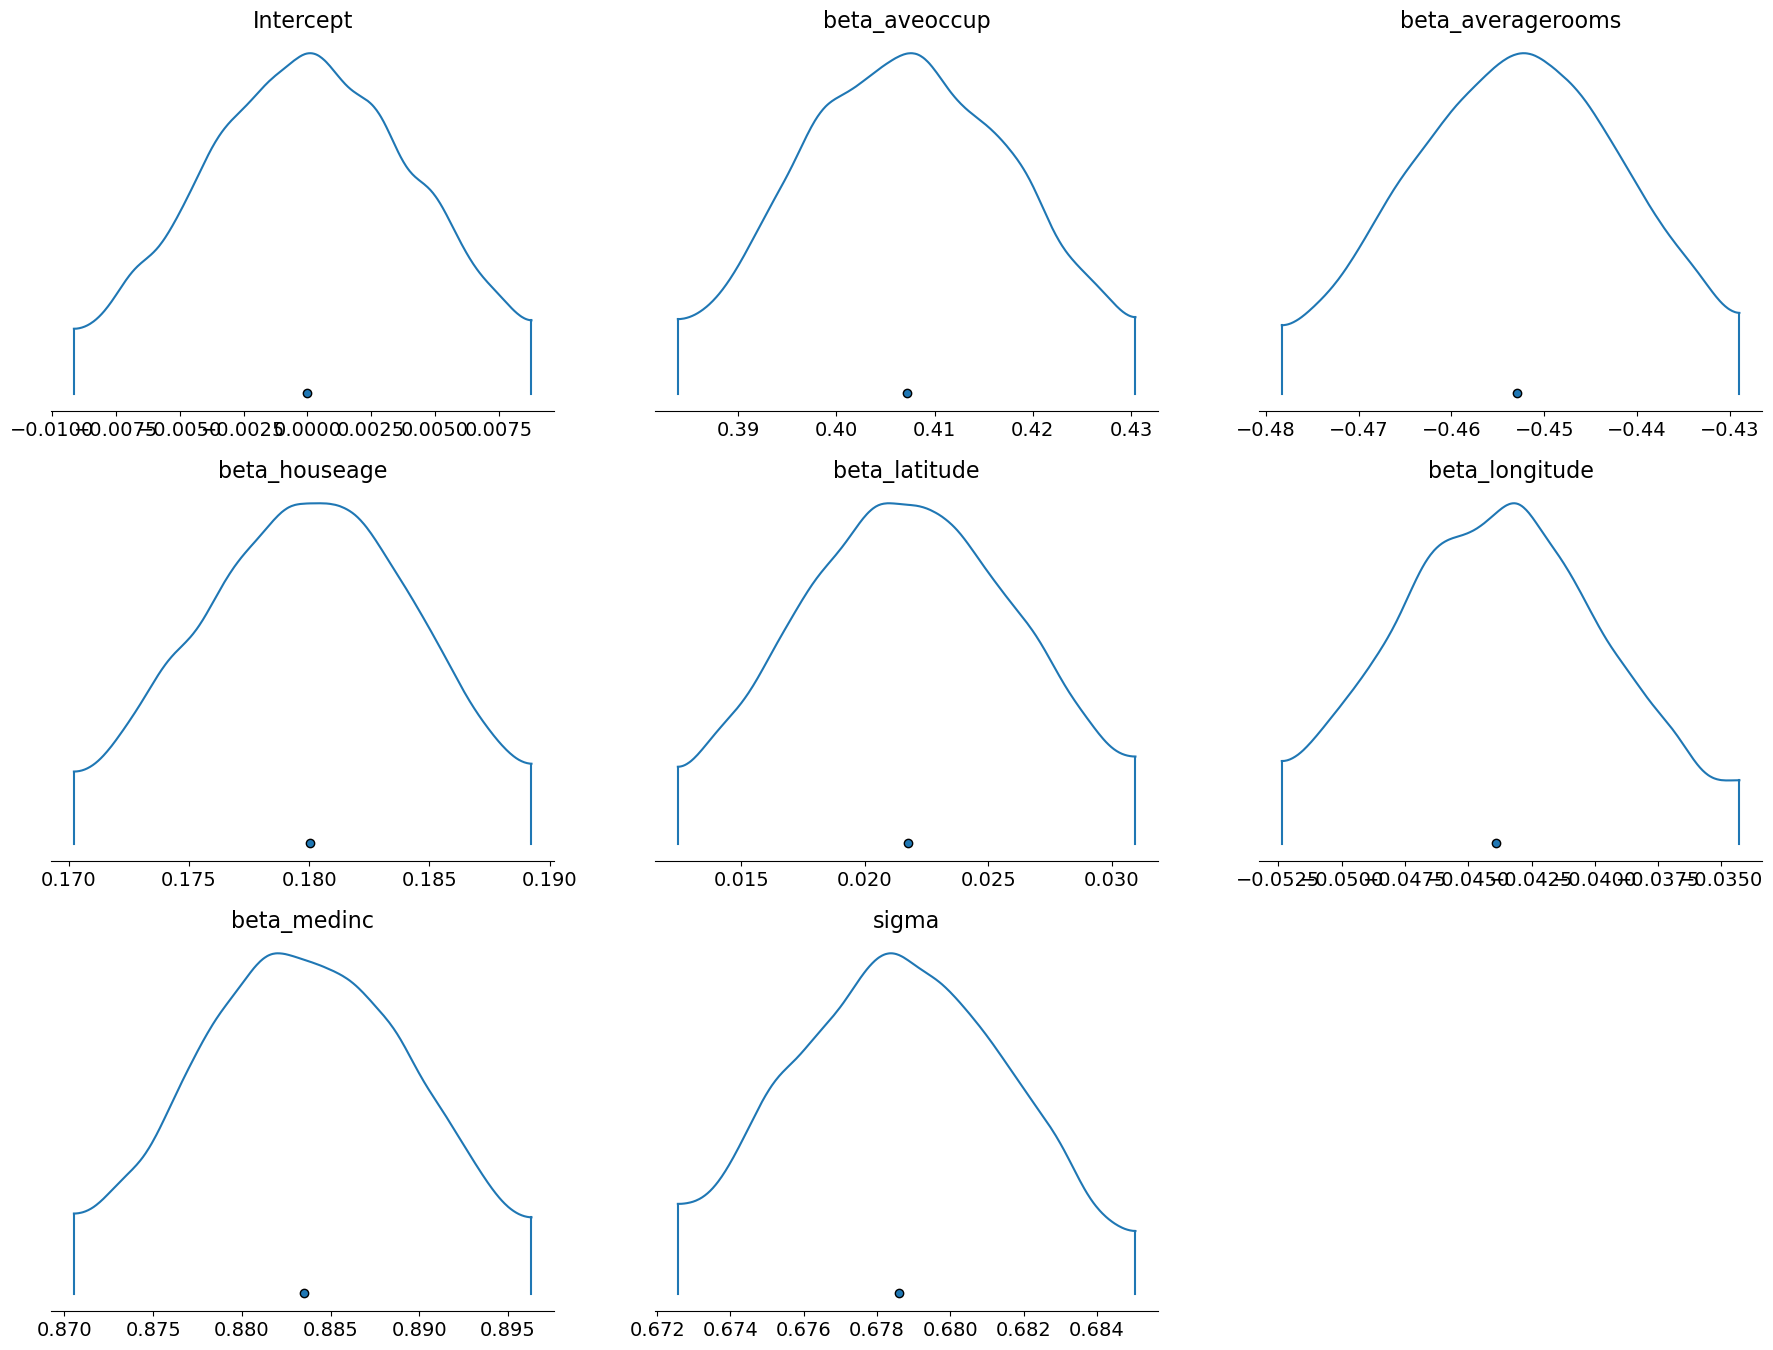

In [ ]:
# az.plot_cdf(trace)
az.plot_density(trace)
plt.show()

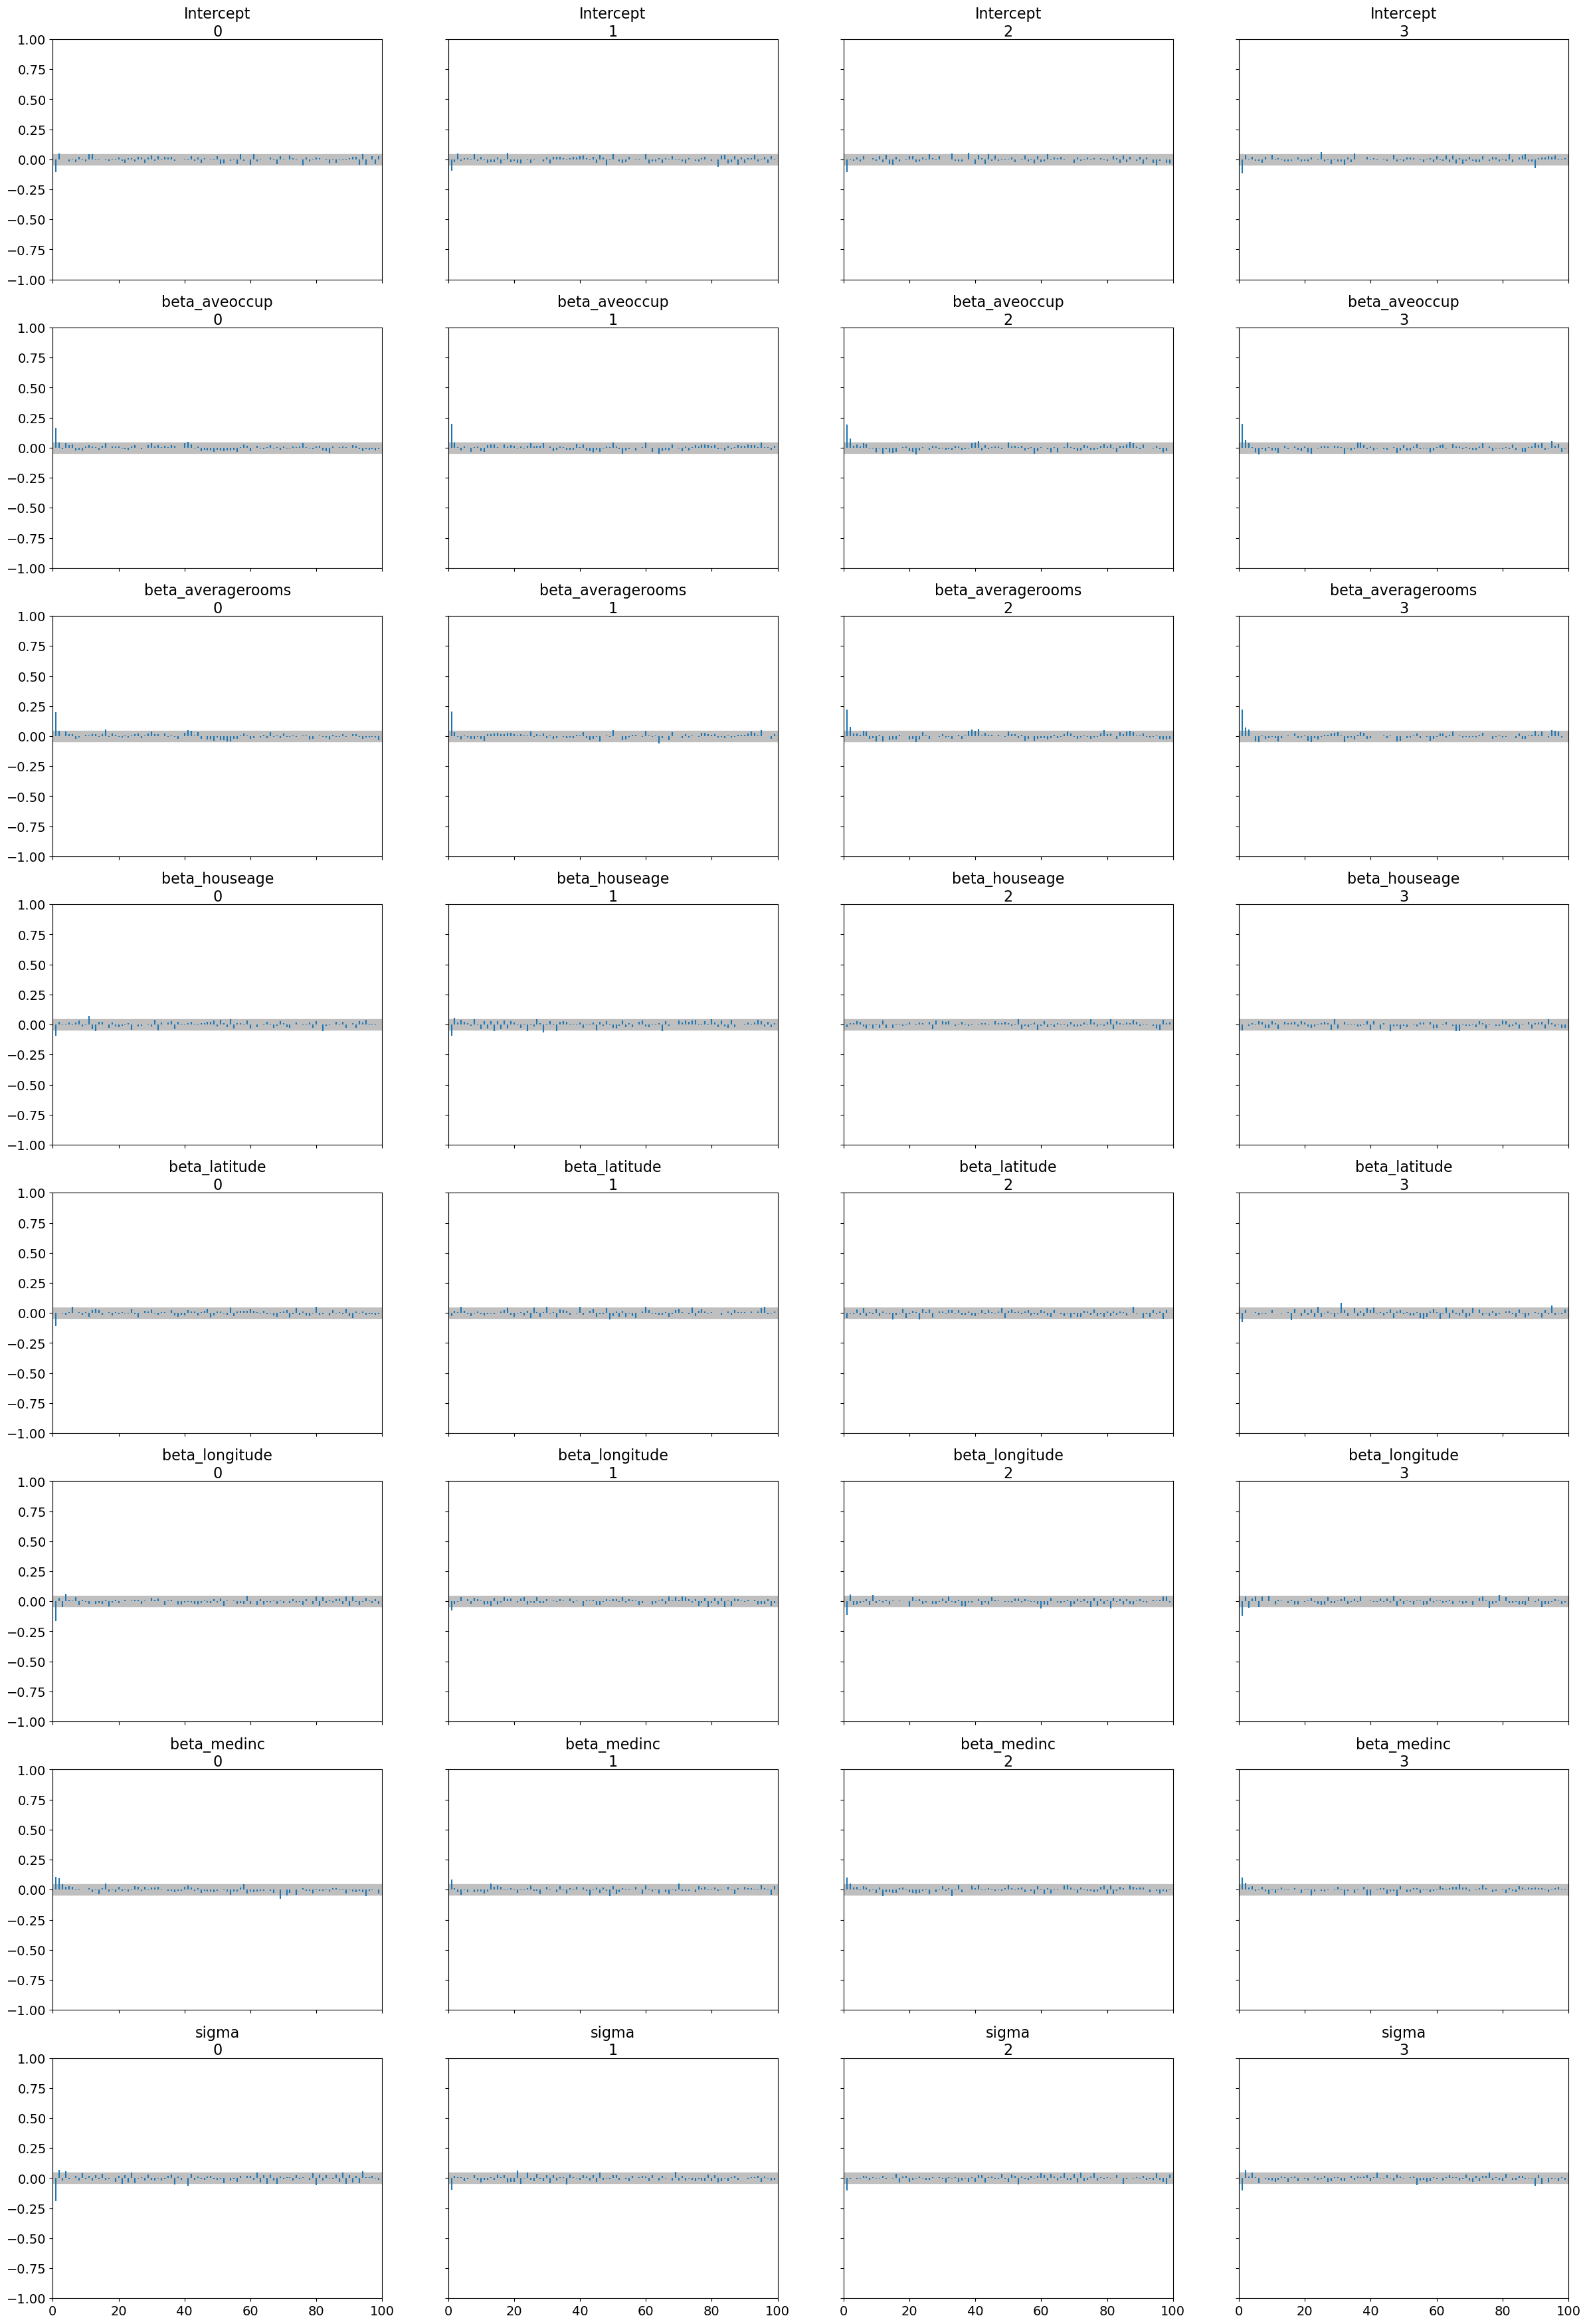

In [ ]:
# az.plot_corr(trace)
az.plot_autocorr(trace)
plt.show()